# Nb-20180312-1833-RandomForest-GainPrediction

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day. 

Add more features...

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [84]:
from collections import defaultdict
import operator

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
import finance as fat

In [5]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [6]:
ticker = 'IBM'

In [7]:
data = fat.get_price_data(ticker)
ohlcv = data

Loaded data for IBM: 1970-01-02 to 2018-03-12.


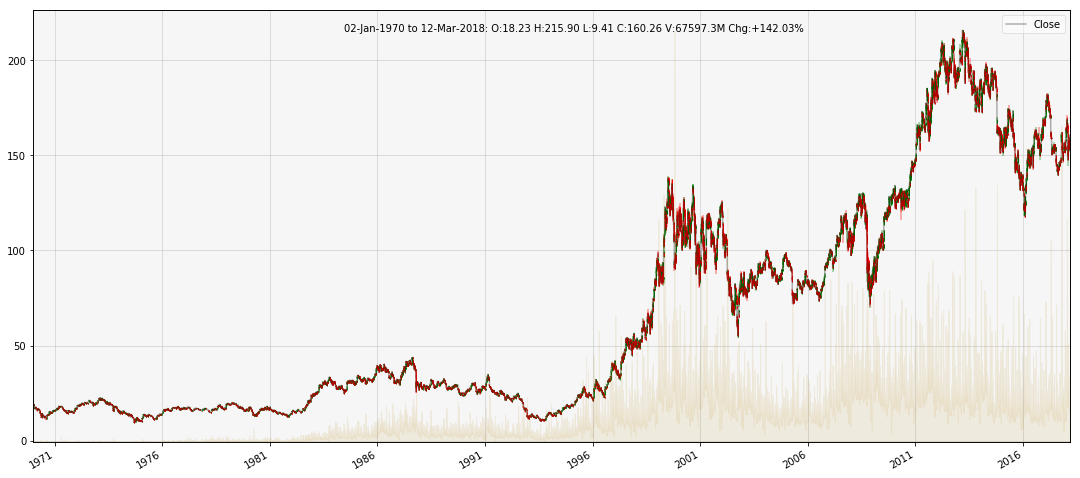

In [8]:
fat.plot_daily_ticker(ohlcv)

In [9]:
# Just use 'Adj Close'
data = pd.DataFrame(data, columns=['Adj Close'])
data.head()

,Adj Close
Date,
1970-01-02,1.689605
1970-01-05,1.705818
1970-01-06,1.706977
1970-01-07,1.708133
1970-01-08,1.711608


Get table with prices for last 5 days, and price for following day.

In [10]:
for i in range(-5, 0, 1) :
    data[f'Adj Close {i}d'] = data['Adj Close'].shift(-i)
data = data.dropna()
data.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d
Date,,,,,,
1970-01-09,1.709291,1.689605,1.705818,1.706977,1.708133,1.711608
1970-01-12,1.703502,1.705818,1.706977,1.708133,1.711608,1.709291
1970-01-13,1.733032,1.706977,1.708133,1.711608,1.709291,1.703502
1970-01-14,1.731295,1.708133,1.711608,1.709291,1.703502,1.733032
1970-01-15,1.767195,1.711608,1.709291,1.703502,1.733032,1.731295


In [11]:
# SMA: 6, 12, 20, 200
data = fat.add_sma_columns(data, 'Adj Close', [6,12])
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12
Date,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835


In [12]:
data = fat.add_ema_columns(data, 'Adj Close', [12,26])
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26
Date,,,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,155.457021,155.845234
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,155.897481,156.028551
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,155.945562,156.041992
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,156.463167,156.284067
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,157.047295,156.578580


In [13]:
data = fat.add_bollinger_bands(data, 'Adj Close')
data.tail()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,
2018-03-06,155.720001,156.550003,155.830002,153.809998,154.490005,156.949997,155.558334,155.494167,155.457021,155.845234,154.106273,159.487779,148.724767
2018-03-07,158.320007,155.830002,153.809998,154.490005,156.949997,155.720001,155.853335,155.672502,155.897481,156.028551,154.331000,160.029191,148.632809
2018-03-08,156.210007,153.809998,154.490005,156.949997,155.720001,158.320007,155.916669,155.760002,155.945562,156.041992,154.524000,160.201118,148.846882
2018-03-09,159.309998,154.490005,156.949997,155.720001,158.320007,156.210007,156.833336,156.205835,156.463167,156.284067,155.110000,160.158154,150.061846
2018-03-12,160.259995,156.949997,155.720001,158.320007,156.210007,159.309998,157.795001,156.795835,157.047295,156.578580,155.647500,160.469219,150.825781


In [14]:
scaled = data.div(data['Adj Close'], axis=0)
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,
1970-01-09,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN
1970-01-12,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,NaN,NaN,1.001558,1.001634,NaN,NaN,NaN
1970-01-13,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,NaN,NaN,0.990544,0.990112,NaN,NaN,NaN
1970-01-14,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,NaN,NaN,0.994209,0.993592,NaN,NaN,NaN
1970-01-15,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,NaN,NaN,0.981073,0.979574,NaN,NaN,NaN


In [15]:
scaled = scaled.dropna()
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,,,,,
1970-02-05,1.0,0.999262,0.989483,1.012547,1.013283,1.013283,1.004643,1.019357,1.018870,1.031163,1.045913,1.128276,0.963551
1970-02-06,1.0,0.972262,0.994924,0.995648,0.995648,0.982596,0.990180,0.999138,1.000957,1.011994,1.024193,1.103417,0.944968
1970-02-09,1.0,0.980701,0.981414,0.981414,0.968549,0.985704,0.982964,0.983366,0.988755,0.997752,1.006978,1.082607,0.931349
1970-02-10,1.0,0.992051,0.992051,0.979046,0.996387,1.010838,0.995062,0.991615,0.999555,1.007801,1.013827,1.084511,0.943143
1970-02-11,1.0,0.966901,0.954226,0.971128,0.985212,0.974649,0.975353,0.968002,0.978255,0.983812,0.985484,1.047656,0.923313


In [16]:
scaled['Gain +1d'] = scaled['Adj Close -1d'].shift(-1) < 1.0
scaled.head()

,Adj Close,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
Date,,,,,,,,,,,,,,
1970-02-05,1.0,0.999262,0.989483,1.012547,1.013283,1.013283,1.004643,1.019357,1.018870,1.031163,1.045913,1.128276,0.963551,True
1970-02-06,1.0,0.972262,0.994924,0.995648,0.995648,0.982596,0.990180,0.999138,1.000957,1.011994,1.024193,1.103417,0.944968,True
1970-02-09,1.0,0.980701,0.981414,0.981414,0.968549,0.985704,0.982964,0.983366,0.988755,0.997752,1.006978,1.082607,0.931349,False
1970-02-10,1.0,0.992051,0.992051,0.979046,0.996387,1.010838,0.995062,0.991615,0.999555,1.007801,1.013827,1.084511,0.943143,True
1970-02-11,1.0,0.966901,0.954226,0.971128,0.985212,0.974649,0.975353,0.968002,0.978255,0.983812,0.985484,1.047656,0.923313,False


In [17]:
del scaled['Adj Close']
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
Date,,,,,,,,,,,,,
1970-02-05,0.999262,0.989483,1.012547,1.013283,1.013283,1.004643,1.019357,1.018870,1.031163,1.045913,1.128276,0.963551,True
1970-02-06,0.972262,0.994924,0.995648,0.995648,0.982596,0.990180,0.999138,1.000957,1.011994,1.024193,1.103417,0.944968,True
1970-02-09,0.980701,0.981414,0.981414,0.968549,0.985704,0.982964,0.983366,0.988755,0.997752,1.006978,1.082607,0.931349,False
1970-02-10,0.992051,0.992051,0.979046,0.996387,1.010838,0.995062,0.991615,0.999555,1.007801,1.013827,1.084511,0.943143,True
1970-02-11,0.966901,0.954226,0.971128,0.985212,0.974649,0.975353,0.968002,0.978255,0.983812,0.985484,1.047656,0.923313,False


### Initial processing

In [18]:
scaled = scaled.reset_index()
scaled.head()

,Date,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Gain +1d
0,1970-02-05,0.999262,0.989483,1.012547,1.013283,1.013283,1.004643,1.019357,1.018870,1.031163,1.045913,1.128276,0.963551,True
1,1970-02-06,0.972262,0.994924,0.995648,0.995648,0.982596,0.990180,0.999138,1.000957,1.011994,1.024193,1.103417,0.944968,True
2,1970-02-09,0.980701,0.981414,0.981414,0.968549,0.985704,0.982964,0.983366,0.988755,0.997752,1.006978,1.082607,0.931349,False
3,1970-02-10,0.992051,0.992051,0.979046,0.996387,1.010838,0.995062,0.991615,0.999555,1.007801,1.013827,1.084511,0.943143,True
4,1970-02-11,0.966901,0.954226,0.971128,0.985212,0.974649,0.975353,0.968002,0.978255,0.983812,0.985484,1.047656,0.923313,False


In [19]:
add_datepart(scaled, 'Date')
scaled.head()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0.999262,0.989483,1.012547,1.013283,1.013283,1.004643,1.019357,1.018870,1.031163,1.045913,...,5,3,36,False,False,False,False,False,False,3024000
1,0.972262,0.994924,0.995648,0.995648,0.982596,0.990180,0.999138,1.000957,1.011994,1.024193,...,6,4,37,False,False,False,False,False,False,3110400
2,0.980701,0.981414,0.981414,0.968549,0.985704,0.982964,0.983366,0.988755,0.997752,1.006978,...,9,0,40,False,False,False,False,False,False,3369600
3,0.992051,0.992051,0.979046,0.996387,1.010838,0.995062,0.991615,0.999555,1.007801,1.013827,...,10,1,41,False,False,False,False,False,False,3456000
4,0.966901,0.954226,0.971128,0.985212,0.974649,0.975353,0.968002,0.978255,0.983812,0.985484,...,11,2,42,False,False,False,False,False,False,3542400


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [20]:
scaled.tail()

,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
12129,1.005330,1.000706,0.987734,0.992101,1.007899,0.998962,0.998550,0.998311,1.000804,0.989637,...,6,1,65,False,False,False,False,False,False,1520294400
12130,0.984272,0.971513,0.975808,0.991347,0.983578,0.984420,0.983278,0.984699,0.985526,0.974804,...,7,2,66,False,False,False,False,False,False,1520380800
12131,0.984636,0.988989,1.004737,0.996863,1.013507,0.998122,0.997119,0.998307,0.998924,0.989207,...,8,3,67,False,False,False,False,False,False,1520467200
12132,0.969745,0.985186,0.977465,0.993786,0.980541,0.984454,0.980515,0.982130,0.981006,0.973636,...,9,4,68,False,False,False,False,False,False,1520553600
12133,0.979346,0.971671,0.987895,0.974729,0.994072,0.984619,0.978384,0.979953,0.977028,0.971219,...,12,0,71,False,False,False,False,False,False,1520812800


In [21]:
train_cats(scaled)

In [22]:
scaled.isnull().sum().sort_index()/len(scaled)

Adj Close -1d          0.0
Adj Close -2d          0.0
Adj Close -3d          0.0
Adj Close -4d          0.0
Adj Close -5d          0.0
Adj Close BBandHi20    0.0
Adj Close BBandLo20    0.0
Adj Close EMA12        0.0
Adj Close EMA26        0.0
Adj Close SMA12        0.0
Adj Close SMA20        0.0
Adj Close SMA6         0.0
Day                    0.0
Dayofweek              0.0
Dayofyear              0.0
Elapsed                0.0
Gain +1d               0.0
Is_month_end           0.0
Is_month_start         0.0
Is_quarter_end         0.0
Is_quarter_start       0.0
Is_year_end            0.0
Is_year_start          0.0
Month                  0.0
Week                   0.0
Year                   0.0
dtype: float64

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [23]:
stamp = "20180312-1833"
file_name = f'data/tmp/{ticker}-{stamp}-gain-raw'

In [24]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [25]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [26]:
dep_col = 'Gain +1d'

In [27]:
df, y, nas = proc_df(df_raw, dep_col)

In [28]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [29]:
len(df_raw)

12134

In [30]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9708, 25), (9708,), (2426, 25))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [31]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [73]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.5360527400082407, 0.49546578730420443]


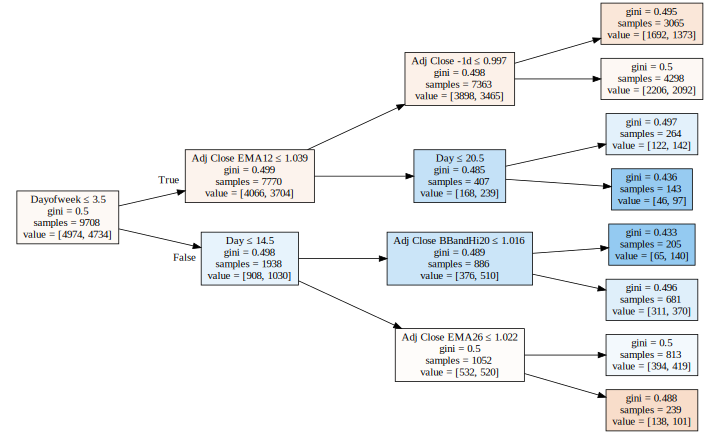

In [74]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [34]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[943, 248],
       [976, 259]], dtype=int64)

## Bagging

In [87]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=20, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.8179851668726823, 0.5070074196207749, 0.5234857849196539]


In [88]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[451, 740],
       [456, 779]], dtype=int64)

In [89]:
metrics.accuracy_score(y_valid, y_pred)

0.5070074196207749

In [90]:
metrics.precision_score(y_valid, y_pred)

0.5128373930217248

In [91]:
metrics.recall_score(y_valid, y_pred)

0.6307692307692307

In [92]:
metrics.f1_score(y_valid, y_pred)

0.5657225853304285

In [93]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
cnf_matrix[1:].sum() / cnf_matrix.sum()

0.5090684253915911

In [97]:
fi = rf_feat_importance(m, df)

In [98]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

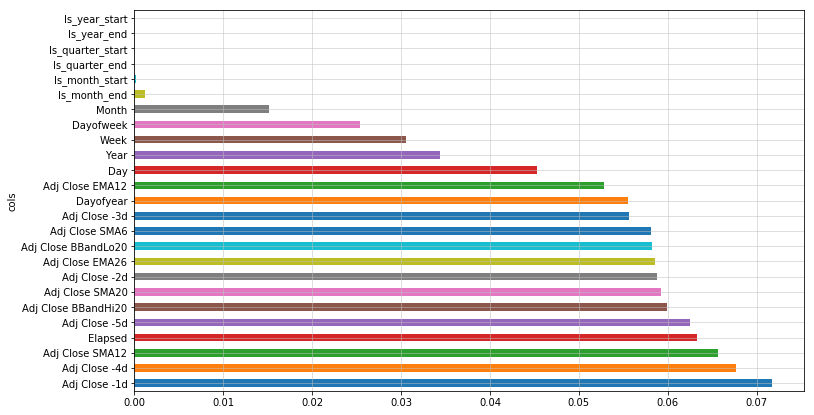

In [99]:
plot_fi(fi)